In [160]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [163]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [164]:
# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

def add_lagged_features(df, n_lags=3):
    for lag in range(1, n_lags + 1):
        df[f'Average_Temp_lag_{lag}'] = df['Average_Temp'].shift(lag)
    return df.dropna().reset_index(drop=True)

train_df = add_lagged_features(train_df)
validation_df = add_lagged_features(validation_df)
test_df = add_lagged_features(test_df)

In [165]:
train_df.head()


,Average_Temp,MW,Year,Month,Day,Hour,Average_Temp_lag_1,Average_Temp_lag_2,Average_Temp_lag_3
0,4.492,32.79130,2021,1,1,3,4.298,4.612,5.186
1,4.066,34.10638,2021,1,1,4,4.492,4.298,4.612
2,4.208,36.87143,2021,1,1,5,4.066,4.492,4.298
3,3.968,40.34799,2021,1,1,6,4.208,4.066,4.492
4,3.684,38.24962,2021,1,1,7,3.968,4.208,4.066


In [166]:
# Preparing the feature sets and target variables
def get_features_targets(df):
    feature_cols = ['Year', 'Month', 'Day', 'Hour', 'Average_Temp'] + [f'Average_Temp_lag_{lag}' for lag in range(1, 4)]  # Assuming 3 lags
    X = df[feature_cols]
    y = df['MW']
    return X, y


X_train, y_train = get_features_targets(train_df)
X_validation, y_validation = get_features_targets(validation_df)
X_test, y_test = get_features_targets(test_df)

In [167]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [168]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [169]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    return LearningRateScheduler(schedule)


# Ensure X_train, X_validation, and X_test are numpy arrays
X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

# Reshape the data for LSTM [samples, time steps, features]
# Assuming that we are treating each sample as an independent observation with 1 time step
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Confirming the shape
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_validation.shape)
print("X_test shape:", X_test.shape)


# Model definition
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, kernel_regularizer=l2(0.01))
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Callbacks
checkpoint_path = '/content/drive/MyDrive/Saved_trained_models/best_rnn_model_V2.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_scheduler = step_decay_schedule(initial_lr=0.001, decay_factor=0.75, step_size=10)

# Model training
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1
)

# Load the best model after training
model.load_weights(checkpoint_path)
print("Model training complete. Best model loaded.")

model.save(checkpoint_path)
print("Model saved at: {}".format(checkpoint_path))


X_train shape: (17516, 1, 8)
X_validation shape: (8758, 1, 8)
X_test shape: (1437, 1, 8)
Epoch 1/50
270/274 [============================>.] - ETA: 0s - loss: 8249.0938
Epoch 1: val_loss improved from inf to 3847.03760, saving model to /content/drive/MyDrive/Saved_trained_models/best_rnn_model_V2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 5s 9ms/step - loss: 8235.0674 - val_loss: 3847.0376 - lr: 0.0010
Epoch 2/50
269/274 [============================>.] - ETA: 0s - loss: 5322.0063
Epoch 2: val_loss improved from 3847.03760 to 2154.94434, saving model to /content/drive/MyDrive/Saved_trained_models/best_rnn_model_V2.h5
274/274 [==============================] - 2s 6ms/step - loss: 5290.2905 - val_loss: 2154.9443 - lr: 0.0010
Epoch 3/50
268/274 [============================>.] - ETA: 0s - loss: 3835.4019
Epoch 3: val_loss improved from 2154.94434 to 2107.83887, saving model to /content/drive/MyDrive/Saved_trained_models/best_rnn_model_V2.h5
274/274 [==============================] - 1s 5ms/step - loss: 3827.7910 - val_loss: 2107.8389 - lr: 0.0010
Epoch 4/50
273/274 [============================>.] - ETA: 0s - loss: 3725.3962
Epoch 4: val_loss did not improve from 2107.83887
274/274 [==============================] - 1s 5ms/step - loss: 3718.1589 - val_loss: 2924.0955 - lr: 0.0010


In [170]:
from keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/Saved_trained_models/best_rnn_model_V2.h5')


In [171]:
predictions = model.predict(X_validation)

274/274 [==============================] - 1s 2ms/step


In [172]:
train_predictions = model.predict(X_train)

# Flatten predictions if they are not already in the correct shape
train_predictions_flattened = train_predictions.flatten()

# Evaluate the model on the training set using your custom function
train_mae, train_mape, train_smape, train_rmse = calculate_metrics(y_train, train_predictions_flattened)

# Print the evaluation metrics for the training set
print(f"Training Set - MAE: {train_mae}, MAPE: {train_mape}, sMAPE: {train_smape}, RMSE: {train_rmse}")


548/548 [==============================] - 1s 2ms/step
Training Set - MAE: 28.483394299599183, MAPE: 36.3346763285426, sMAPE: 37.54128641259396, RMSE: 60.69019876338804


In [173]:
# Ensure predictions are 1D
predictions = predictions.squeeze()

# If necessary, also ensure y_validation is 1D
y_validation = y_validation.squeeze()  # This line may be unnecessary if y_validation is already 1D

# Now, evaluate the model using your custom function
mae, mape, smape, rmse = calculate_metrics(y_validation, predictions)

# Print the evaluation metrics
print(f"MAE: {mae}, MAPE: {mape}, sMAPE: {smape}, RMSE: {rmse}")

MAE: 30.761726135873555, MAPE: 47.77209741959052, sMAPE: 49.367967961688215, RMSE: 45.434485307963534


In [174]:
import numpy as np

# Assuming you've already made predictions and have your model and data ready

# Ensure predictions are 1D
predictions = predictions.squeeze()

# If necessary, also ensure y_validation is 1D
# This line may be unnecessary if y_validation is already 1D
y_validation_array = np.array(y_validation)  # Ensure y_validation is a numpy array
y_validation_squeezed = y_validation_array.squeeze()

# Now, evaluate the model using your custom function
mae, mape, smape, rmse = calculate_metrics(y_validation_squeezed, predictions)

# Print the evaluation metrics
print(f"MAE: {mae}, MAPE: {mape}, sMAPE: {smape}, RMSE: {rmse}")


45/45 [==============================] - 0s 2ms/step
test set: MAE: 22.655109532548277, MAPE: 28.35991018383215, sMAPE: 33.38247334656651, RMSE: 41.39687839822667


In [175]:
print(predictions)

[52.237526 52.69582  52.93183  ... 87.56928  88.23787  88.952095]


In [176]:
print(y_validation)

0       112.82553
1       108.65000
2       107.50238
3       110.89439
4       126.76553
          ...    
8753     50.05301
8754     50.08335
8755     49.23503
8756     46.34927
8757     45.81851
Name: MW, Length: 8758, dtype: float64


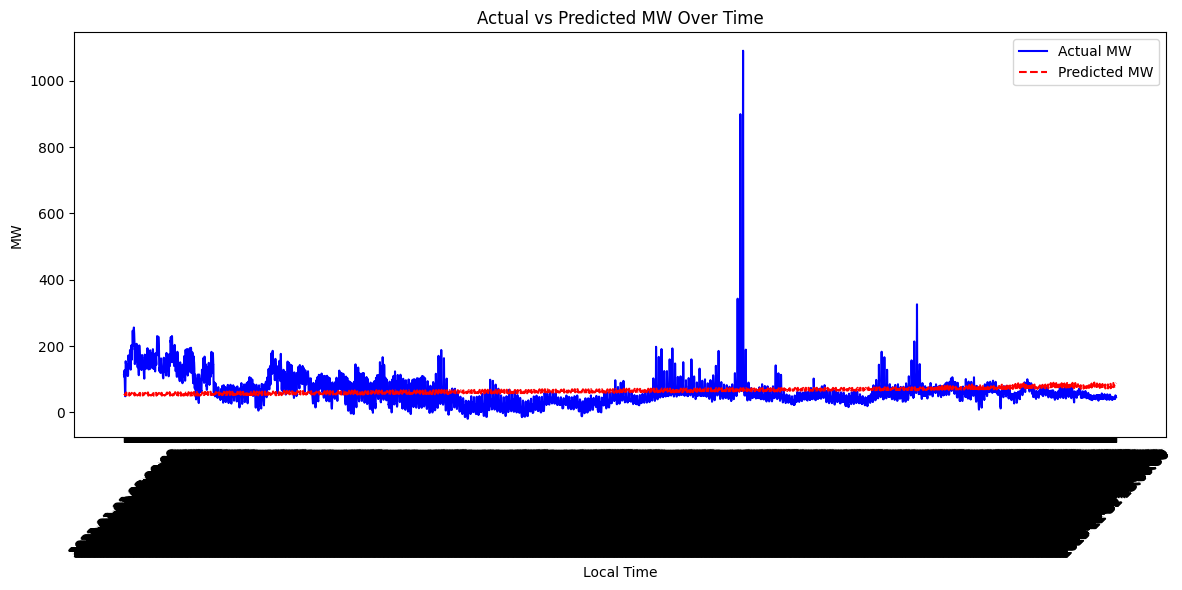

In [177]:
# Flatten predictions to make it 1-dimensional
import matplotlib.pyplot as plt

validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv', usecols=['local_time'])
# Extract the datetime series
validation_local_time = validation_df['local_time']

predictions_flattened = predictions.flatten()

min_length = min(len(validation_local_time), len(predictions_flattened), len(y_validation))

validation_local_time = validation_local_time[:min_length]
predictions_flattened = predictions_flattened[:min_length]
y_validation_aligned = y_validation[:min_length]

plt.figure(figsize=(12, 6))
plt.plot(validation_local_time, y_validation_aligned, label='Actual MW', color='blue')
plt.plot(validation_local_time, predictions_flattened, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW Over Time')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


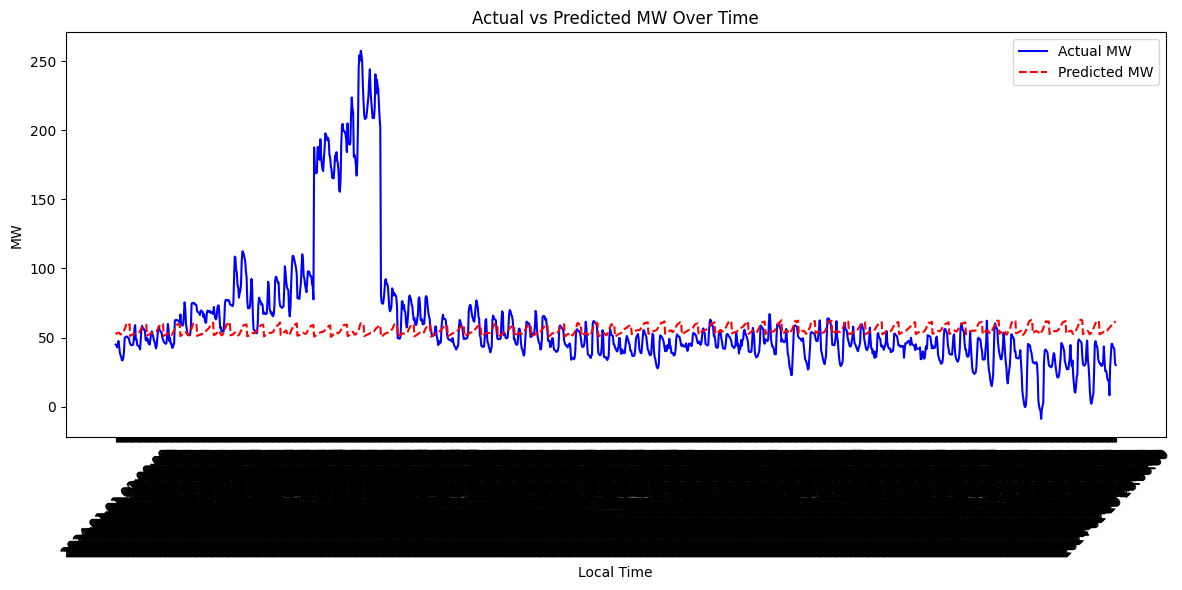

In [178]:
# Flatten predictions to make it 1-dimensional
import matplotlib.pyplot as plt

test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
# Extract the datetime series
test_local_time = test_df['local_time']

predictions_flattened = predictions_test.flatten()

min_length = min(len(test_local_time), len(predictions_flattened), len(y_test))

test_local_time = test_local_time[:min_length]
predictions_flattened = predictions_flattened[:min_length]
y_test_aligned = y_test[:min_length]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test_aligned, label='Actual MW', color='blue')
plt.plot(test_local_time, predictions_flattened, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW Over Time')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
